# Fitting basics

#### Marcel Lüthi, Departement Mathematics and Computer Science, University of Basel 

In the first part of the course, we defined a regression model for our toy problem. We performed prior predictive checks to understand what our choice of prior implies as constraints for the model. In this notebook we return to the toy problem. We will fit the model to data and assess the fitting quality through different techniques.  Along the way, we will also learn how we can setup a Metropolis-Hastings algorithm in Scalismo. 

### Setup and imports

We start as always by setting up the environment, loading the necessary libraries and doing the necessary import. 

In [1]:
// Suppressing excessive output for the jupyter-notebook
val api = implicitly[almond.api.JupyterApi]
api.silent(true)

api: JupyterApi = almond.JupyterApiImpl@42b70e82

In [2]:
import coursierapi.{Credentials, MavenRepository}
interp.repositories() ++= Seq(
  MavenRepository.of("https://oss.sonatype.org/content/repositories/snapshots")
)



In [3]:
// downloading the library 
import $ivy.`ch.unibas.cs.gravis::scalismo-plot:0.1-SNAPSHOT`
import $ivy.`org.scalanlp::breeze:2.1.0`
import $ivy.`org.scalanlp::breeze-natives:2.1.0`

In [3]:
// imports
import scalismo.geometry._
import scalismo.common.PointId
import scalismo.sampling._
import scalismo.sampling.proposals._
import scalismo.sampling.parameters._
import scalismo.sampling.evaluators._
import scalismo.sampling.loggers.MHSampleLogger
import scalismo.sampling.algorithms.MetropolisHastings
import scalismo.mesh.LineMesh

import scalismo.plot.data.DataFrame
import scalismo.plot.plottarget.PlotTarget.plotTargetJupyter
import java.lang.Math

import breeze.linalg.DenseVector
import breeze.linalg.DenseMatrix
import breeze.stats.distributions.{Gaussian, MultivariateGaussian}
import breeze.stats.distributions.Rand.FixedSeed.randBasis

import java.io.File

: 

Before we can use Scalismo, we need to call initialize it and define the random number generater that we will use. 

In [ ]:
scalismo.initialize()
given rng : scalismo.utils.Random = scalismo.utils.Random(42)

### Fitting to data

Recall that in the previous notebook we defined the following model (potentially with different priors)

$$
\text{length} \sim N(a \cdot \text{span} + b, \sigma ) \\
a \sim N(1, 1) \\
b \sim Uniform(0, 10) \\
\sigma \sim lognormal(0, 0.25)
$$

The goal of fitting is to use data to learn what are the likely values of the parameters. Ultimately, we will fit it to measurements of the hand. However, in a first step it is always a good idea to fit it to simulated data from the prior in order to understand if our fitting procedure works as expected. 


### Simulating data

To simulate data, we fix some values for the priors and sample from the likelihood:

In [ ]:
case class SpanAndLength(span : Double, length : Double)

def generate(span : Double, a : Double, b : Double, sigma : Double) : SpanAndLength =
    val likelihood = Gaussian(a * span + b, sigma)
    val length = likelihood.draw()
    SpanAndLength(span, length)

In [ ]:
val spanModel = Gaussian(20, 5)
val data = for i <- 0 until 100 yield
    val span = spanModel.draw()
    generate(span, a = 1, b = 3, sigma = 2)

As always, it is a good idea to plot the data:

In [ ]:
DataFrame(Seq(
    DataFrame.Column.ofContinuous(data.map(d => d.span), "span"),
    DataFrame.Column.ofContinuous(data.map(d => d.length), "length")
    )
).plot.scatterPlot("span", "length", "span vs length").show()

### Setting up the sampler 

The first step in setting up the sampler is to define a class that can hold all the parameters. 
$
\theta = (a,b,\sigma) \\
$

In [ ]:
case class Parameters(a : Double, b:  Double, sigma : Double)

Scalismo provides us with ready made components for creating possible parameter vectors. But Scalismo does not know about our Parameter class, but only about Tuples of numbers. To bridge this gap, we define how the parameters are converted to and from a tuple.  

In [ ]:
given tuple3ParameterConversion : ParameterConversion[Tuple3[Double, Double, Double], Parameters] with 
    def from(p: Parameters): Tuple3[Double, Double, Double] = (p.a, p.b, p.sigma)
    def to(t: Tuple3[Double, Double, Double]): Parameters = Parameters(a = t._1, b = t._2, sigma = t._3)

### Evaluators: Modelling the target density
In Scalismo, the density from which we want to sample is modelled by a class `MHDistributionEvaluator`. The posterior is decomposed into several densities: A prior for each parameter and a likelihood. We first define all the prior distributions:

In [ ]:
object PriorAEvaluator extends MHDistributionEvaluator[Parameters]:

    val priorDistA = breeze.stats.distributions.Gaussian(1, 1)

    override def logValue(theta: MHSample[Parameters]): Double = 
      priorDistA.logPdf(theta.parameters.a)

object PriorBEvaluator extends MHDistributionEvaluator[Parameters]:

    val priorDistB = breeze.stats.distributions.Gaussian(0, 10)

    override def logValue(theta: MHSample[Parameters]): Double = 
        priorDistB.logPdf(theta.parameters.b)

object PriorSigmaEvaluator extends MHDistributionEvaluator[Parameters]:

    val priorDistSigma = breeze.stats.distributions.LogNormal(0, 0.25)

    override def logValue(theta: MHSample[Parameters]): Double = 
        priorDistSigma.logPdf(theta.parameters.sigma)

The likelihood looks as follows: Note, that since we specify the likelihood in terms of log probabilities, products turn into sum and hence for independent observations we just sum up each individual likelihood:

In [ ]:
case class LikelihoodEvaluator(data: Seq[SpanAndLength]) extends MHDistributionEvaluator[Parameters]:

    override def logValue(theta: MHSample[Parameters]): Double = 

      val likelihoods = for (SpanAndLength(span, length) <- data) yield 
        val likelihood = breeze.stats.distributions.Gaussian(
          theta.parameters.a * span + theta.parameters.b,
          theta.parameters.sigma
        )
        likelihood.logPdf(length)
      likelihoods.sum
    
  

The target density (i.e. the posterior distribution) can be computed by taking the product of the prior and the likelihood.

In [ ]:
val posteriorEvaluator = ProductEvaluator(PriorAEvaluator, PriorBEvaluator, PriorSigmaEvaluator, LikelihoodEvaluator(data))

### The proposal generator

Now that the evaluators are in place, our next task is to set up the proposal distributions. In Scalismo, we can define a proposal distribution by implementing concrete subclasses, of the following class 

```scala 
abstract class MHProposalGenerator[A]  {
   def propose(current: A): A
   def logTransitionProbability(from: A, to: A): Double
}
```

The type A refers to the type of the parameters that we are using. The propose method takes the current parameters and, based on their values, proposes a new one. The method logTransitionProbability yields the logProbability of transitioning from the state represented by the parameter values from to the state represented by the parameter values in to.

Fortunately, we usually do not have to implement these methods by ourselves. Scalismo already provides some proposal generators, which can be flexibly combined to build up more powerful generators.

The most generic one is the GaussianRandomWalkProposal, which takes the given parameters and perturbs them by adding an increment from a zero-mean Gaussian with given standard deviation. The following codes defines a proposal for each of our parameter vectors.

In [ ]:
val genA = GaussianRandomWalkProposal(0.01, "rw-a-0.1").forType[Double]
val genB = GaussianRandomWalkProposal(0.05, "rw-b-0.5").forType[Double]
val genSigma = GaussianRandomWalkProposal(0.01, "rw-sigma-0.01").forType[Double]

As we expect the distribution to have more variability in the value of bb than aa, we choose the values for the step size (standard deviation) accordingly. We also provide a tag when defining a proposal generator. This is helpful for debugging and optimizing the chain. Finally, note also that we explicitly specified a type (here Double) of the specified sample.

We can now combine these individual proposal generators to a proposal generator for our Parameter class as follows:

In [58]:
val parameterGenerator = MHProductProposal(genA, genB, genSigma).forType[Parameters]

It might also be a good idea to sometimes only vary the noise genSigma but not the other parameters. To achieve this, we introduce another proposal, the MHIdentityProposal. As the name suggests, it does not do anything, but simply returns the same parameters it gets passed. While this does not sound very useful by itself, by combining it with other proposals we can achieve our goal:

In [59]:
val identProposal = MHIdentityProposal.forType[Double]
val noiseOnlyGenerator = MHProductProposal(identProposal, identProposal, genSigma).forType[Parameters]

We have now two different generators, which generate new parameters given a current set of parameter values. A good strategy is to sometimes vary all the parameters, and sometimes only the noise. This can be done using a MHMixtureProposal:

In [60]:
val mixtureGenerator = MHMixtureProposal((0.1, noiseOnlyGenerator), (0.9, parameterGenerator))

In this case we use the noiseOnlyGenerator 10% of the times and the parameterGenerator 90% of the times. 

### Building the Markov Chain

Now that we have all the components set up, we can assemble the Markov Chain.



In [61]:
val chain = MetropolisHastings(mixtureGenerator, posteriorEvaluator)


To be able to diagnose the chain, in case of problems, we also instantiate a logger, which logs all the accepted and rejected samples. 

In [62]:
val logger = MHSampleLogger[Parameters]()

The Markov chain has to start somewhere. We define the starting point by defining an initial sample.

In [63]:
val initialSample = MHSample(Parameters(0.0, 0.0, 1.0), generatedBy="initial")


To drive the sampling generation, we define an interator, which we initialize with the initial sample. We also provide the logger as an argument. 

In [64]:
val mhIterator = chain.iterator(initialSample, logger)

Our initial parameters might be far away from a high-probability area of our target density. Therefore it might take a few hundred or even a few thousand iterations before the produced samples start to follow the required distribution. We therefore have to drop the samples in this burn-in phase, before we use the samples:

In [86]:
val samples = mhIterator.drop(1000).take(5000).toIndexedSeq

Now that we have the samples, we can visualize the distribution of the individual parameters and see how well the samples approximate our simulated data. A useful tool is a pairplot, which gives a histogram of the given parameters as well as a scatterplot for all pairs of parameters against each other. 

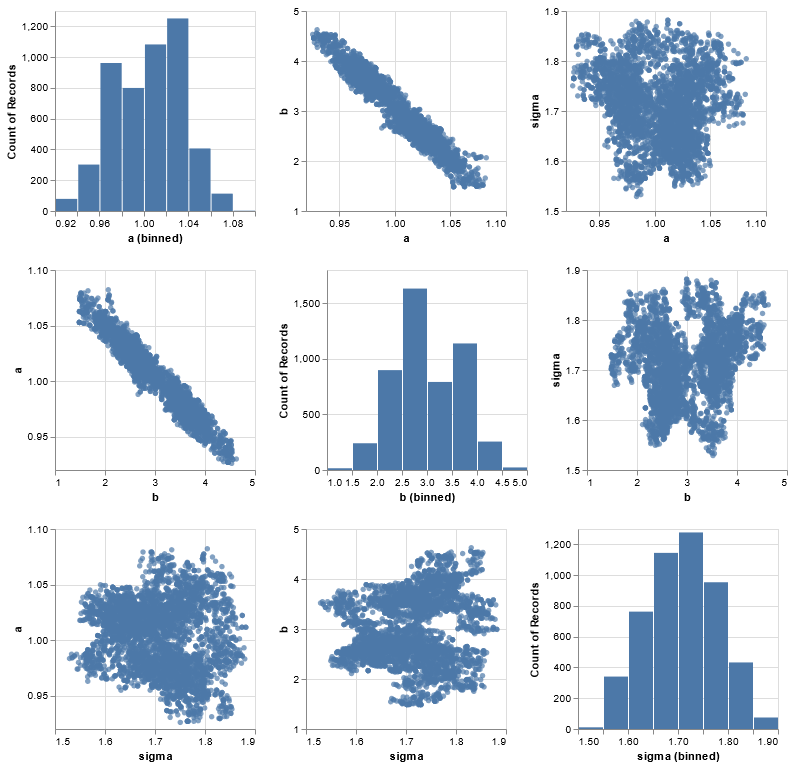

In [96]:
val df = DataFrame(Seq(
    DataFrame.Column.ofContinuous(samples.map(s => s.parameters.a), "a"), 
    DataFrame.Column.ofContinuous(samples.map(s => s.parameters.b), "b"),
    DataFrame.Column.ofContinuous(samples.map(s => s.parameters.sigma), "sigma")
    )
)

df.plot.pairPlot(Seq("a", "b", "sigma"), title = "Pairs").show()

### Debugging the Markov chain

The logger that we defined for the chain stored all the accepted and rejected samples. We can use this to get interesting diagnostics.

For example, we can check how often the individual samples got accepted.

In [68]:
println("Acceptance ratios: " +logger.samples.acceptanceRatios)

Acceptance ratios: Map((rw-a-0.1, rw-b-0.5, rw-sigma-0.01) -> 0.6129151291512915, (ident, ident, rw-sigma-0.01) -> 0.9499136442141624)


When running this code we see that the acceptance ratio of the proposal where we vary all the parameters, is around 0.12. The proposal, which only changes the noise value has, as expected, a much higher acceptance ratio of aroun 0.75.

Sometimes it happens that a chain is efficient in the early stages (the burn-in phase), but many samples get rejected in later stages. To diagnose such situations, we can compute the acceptance ratios also only for the last nn samples:

In [29]:
println("acceptance ratios over the last 100 samples: " +logger.samples.takeLast(100).acceptanceRatios)

acceptance ratios over the last 100 samples: Map((rw-a-0.1, rw-b-0.5, rw-sigma-0.01) -> 0.10344827586206896, (ident, ident, rw-sigma-0.01) -> 0.8461538461538461)


Such diagnostics helps us to spot when a proposal is not effective and gives us an indication how to tune our sampler to achieve optimal performance.

### Posterior predictive checks

Using the simulated data, we could quickly check that the posterior estimate is reasonable. However, in practice we don't have the ground truth for the parameters available. One way to check if the posterior values are resaonable, is to simulate values from the posterior and to plot them. We can for example simulate data using the parameters of from the posterior samples, and plot them along with the data from which we learned. If the distributions look similar, we are confident that we found reasonable values. 

In [97]:
val equidistantSamples = samples.grouped(samples.length / 100).map(_.head).toSeq
val sampledPairs = for sample <- equidistantSamples yield
    val span = spanModel.draw()
    generate(span, sample.parameters.a, sample.parameters.b, sample.parameters.sigma)

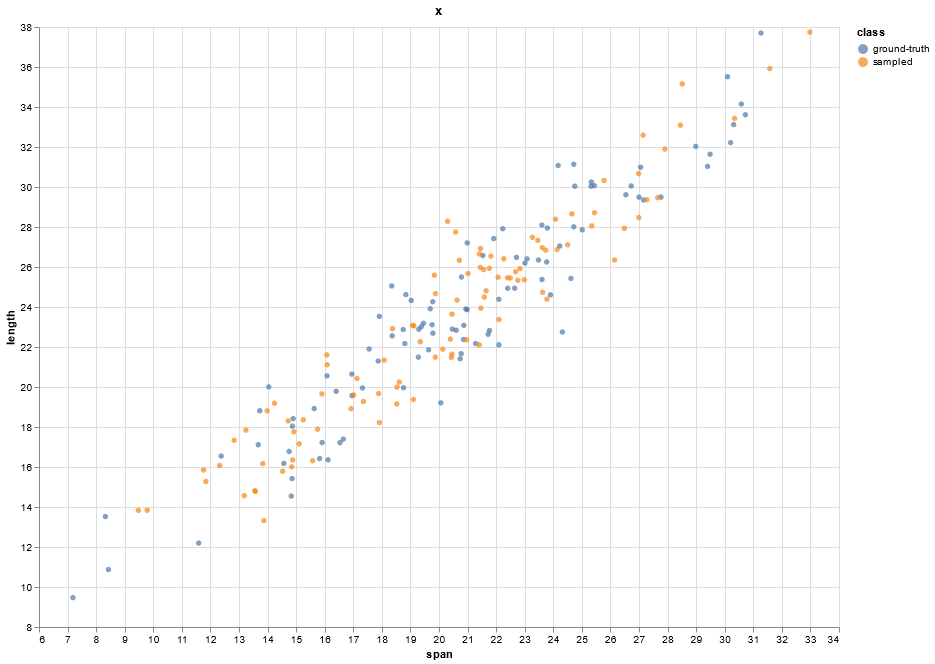

In [98]:
val dataFrameForData = DataFrame(Seq(
    DataFrame.Column.ofContinuous(data.map(d => d.span), "span"),
    DataFrame.Column.ofContinuous(data.map(d => d.length), "length"),
    DataFrame.Column.ofNominals(Seq.fill(data.length)("ground-truth"), "class")
    )
)

val dataFrameForSamples = DataFrame(Seq(
    DataFrame.Column.ofContinuous(sampledPairs.map(d => d.span), "span"),
    DataFrame.Column.ofContinuous(sampledPairs.map(d => d.length), "length"),
    DataFrame.Column.ofNominals(Seq.fill(sampledPairs.length)("sampled"), "class")
    )
)

dataFrameForData.concat(dataFrameForSamples).plot.scatterPlot("span", "length", title = "x", colorField="class").show()

### Exercises

* Repeat the same procedure for the original data. How well did the fitting work?
* What happens when you change the priors? Choose very narrow and very wide priors. Do you see a difference?
* Can you think of quantitative ways to compare the fit (samples from the posterior) and the data? Can you implement them?
* Can you plot a few lines defined by the samples, as you did for the prior predictive checks? 